<a href="https://colab.research.google.com/github/tornermarton/deep_learning_project/blob/master/dl_project_loremimpsum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authorship identification using deep learning
**Füleki Fábián,	Jani Balázs Gábor,	Torner Márton**  
*Project work for BME Deep Learning course (VITMAV45),  
Team: LoremIpsum*


**Milestone I**

**Dataset:**  
Our primary dataset is the Reuters_50_50 (C50), which is a subset of Reuters Corpus Volume I(RCVI). The RCV1 is archive of categorized newswire stories, made public for research purposes by Reuters, Ltd. The C50 collection consist of 50 texts for each of the 50 top author, for training and separately the same amount for testing purpose (5000 texts in total). This dataset has been previous used by previous studies of authorship recognition and can be found here: https://archive.ics.uci.edu/ml/machine-learning-databases/00217/C50.zip



## Prepaing Dataset and visualizing the result

**Milestone I**

In [6]:
# Clean storage for new files
!rm -r C50*

# Download of the Reuter_50_50 (C50) dataset
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00217/C50.zip"
!unzip -q C50.zip

# Download contains 2 directories split, merge them (we will do custom splitting)
!mkdir C50
!mv C50train/* C50/
!rsync -a C50test/ C50/

# Clean files we don't need
!rm C50.zip
!rm -r C50train
!rm -r C50test

rm: cannot remove 'C50*': No such file or directory
--2018-10-31 17:01:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/00217/C50.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8194031 (7.8M) [application/zip]
Saving to: ‘C50.zip’

C50.zip             100%[===================>]   7.81M  2.15MB/s    in 3.6s    

2018-10-31 17:01:57 (2.15 MB/s) - ‘C50.zip’ saved [8194031/8194031]



In [7]:
# Download and install the largest language pack for SpaCy
# It contains 1 000 000 word vectors (so only very rare words can't be processed)
!python -m spacy download en_core_web_lg

    100% |████████████████████████████████| 852.3MB 46.6MB/s 
  Running setup.py install for en-core-web-lg ... - \ | / - \ | / - \ done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



In [0]:
# Get required resources
import spacy
import math
import time
import pandas as pd
import nltk
import os
import sys
import numpy as np
from nltk import tokenize
from keras.utils import np_utils



In [0]:
nltk.download('punkt')
pd.set_option("max_columns", None)
nlp = spacy.load('en_core_web_lg', disable=['ner','parser'])

In [0]:
def read_sentences_from_file(author, author_id, filename):
  data = ""
  sentences = []

  # parse file
  with open("C50/"+author+"/"+filename, 'r') as file:
      data=file.read()
      
  # split article into sentences
  for sentence in tokenize.sent_tokenize(data):
    sentences.append([author_id, sentence])
  
  return sentences

In [0]:
# authors must be represented as numbers so we create
# a list and the indexes are the repesentations - easy translation

# array which contains the authors' names
authors = []

# translate back id - clear result
def match_author(id):
  return authors[id]

In [0]:
def load_raw_sentences():
  raw_sentences = []
  authors = []
  # read every file (articles) in the previously given root directory, the subdirectories are the authors' names
  for root, dirs, files in os.walk("C50"):
    for dir in dirs:
      authors.append(str(dir))
      for file in os.listdir("C50/"+dir):
        raw_sentences.extend(read_sentences_from_file(dir, len(authors)-1, file))

  return raw_sentences, authors

**Sentence parsing**

We parse all the sentences with SpaCy in the followig way:

1. Tokenize the sentence (split into words - in SpaCy the punctuation characters also count as words, but we remove them later, because they do not contain needed information)

2. Get the vector form of each word, if it is not part of the largest collection (very rare words) we leave them out, because we can only use vectors for the inputs.

3. Detect for each word which part of the sentence it is (part-of-speech tags - syntactic information)


In [0]:
def parse_raw_sentences(sentences, verbose=False):
  # just for writing out fancy things
  if verbose:
    start_time = time.time()
    s = ""
    
  parsed_sentences = np.empty([len(sentences)], dtype=[('author', object, 1), ('original', object, 1), ('parsed', object, 1)])
  
  # parse every sentence (word splitting -> tokens, determine part-of-speech tags for every word)
  end = len(sentences)
  for i in range(0, end):
    author = sentences[i][0]
    raw_sentence = sentences[i][1]
    parsed = np.array([], dtype=[('text', object, 1), ('vector', object, 1), ('pos_str', object, 1), ('pos_num', object, 1)])
    
    doc = nlp(raw_sentence)
   
    for token in doc:
      # filter out stop words (not relevant/useful)
      # 96 = punctuation char (->SpaCy documentation)
      # if a word does not have vector form filter it out (very, very rare case)
      if not token.is_stop and not token.pos == 96 and token.has_vector:
        parsed = np.append(parsed, np.array((token.text, token.vector, token.pos_, token.pos), dtype=[('text', object, 1), ('vector', object, 1), ('pos_str', object, 1), ('pos_num', object, 1)]))
    
      parsed_sentences[i] = (author, raw_sentence, parsed)
    
    # just for writing out fancy things
    if verbose and (i+1)%1000 == 0 or i == end-1:
      if i != 0: 
        s =  str(i+1)+ "/" + str(end) +" sentences parsed in " +str(round(time.time() - start_time))+ " seconds."
      
      j = int((i+1)/end*50)
    
      sys.stdout.write('\r'+ "Processing. [" + "="*j + ">" + " "*(50-j) + "] " + s )
  
  if verbose:
    print('\n' + "Sentences successfully parsed.")
  
  return parsed_sentences

In [0]:
def count_avg_sentence_len(sentences):
  sum = 0
  count = 0
  for sentence in sentences['parsed']:
    if type(sentence).__name__ == "NoneType":
        print(sentence)
        print(count)
    sum += len(sentence)
    count += 1
  
  return sum/count

**Equalization of the sentences in the dataset**

We plan to use sentence based identification so out system needs sentences which have equal lengths (word count), but obviously the articles are not written in this way, so we have to make the equalization. We calculate the average word count of the sentences in the dataset and then we transform all of them to contain the same number of words (we round up the average to keep more sentences in the full form).

Too short sentences are extended with wildcard (magic) words which will be filtered out in a way in the learning process.

Too long sentences are simply cut to shape.

In [0]:
def equalize_sentence_len(sentences):
  # calculate the average sentence length and round it up (we try to keep most of the sentences)
  avg = math.ceil(count_avg_sentence_len(sentences))
  
  equalized_sentences = np.empty([len(sentences)], dtype=[('author', object, 1), ('original', object, 1), ('parsed', object, 1)])
  
  n_sentences = 0
  
  # process 
  for i in range(0, len(sentences)):
    sentence = sentences[i]
    
    sys.stdout.write('\r'+ str(i) +" sentences equalized.")
    
    if len(sentence['parsed']) > 7:
      n_sentences += 1
      
      # 'magic words' : text = Xxxxxx ; vector=nullvector ; pos_tag='' ; pos_tag number form : 0
      # insert magic word into random positions for every sentence, which is too short (shorter, than average)
      while len(sentence['parsed']) < avg:
        idx = np.random.randint(len(sentence['parsed']))
        sentence['parsed'] = np.insert(sentence['parsed'], idx, np.array(("Xxxxxx", np.zeros(300), "", 0), dtype=[('text', object, 1), ('vector', object, 1), ('pos_str', object, 1), ('pos_num', object, 1)]), axis=0)

      # if sentence is too long cut it
      if len(sentence['parsed']) > avg:
        sentence['parsed'] = sentence['parsed'][0:avg]
        
      equalized_sentences[n_sentences-1] = sentence
  
  print('\n')
  return equalized_sentences[:n_sentences]

In [15]:
raw_sentences, authors = load_raw_sentences()
print("Total number of the loaded sentences: " + str(len(raw_sentences)))

Total number of the loaded sentences: 108473


In [16]:
#load only the first 10000 sentences for demonstration (parsing 100000+ sentences would be 10+ minutes) 96k - 97k
dataset = parse_raw_sentences(raw_sentences[:60000], True)

Processing. [==================================================>] 60000/60000 sentences parsed in 429 seconds.
Sentences successfully parsed.


In [0]:
dataset_safe = dataset

In [18]:
avg_before = count_avg_sentence_len(dataset)
print("The average sentence length before the equalization: " + str(avg_before) + '\n')

# equalize the length of the sentences (we need the number of words to be equal)
dataset = equalize_sentence_len(dataset)

avg_after = count_avg_sentence_len(dataset)
print("And after: " + str(avg_after))

The average sentence length before the equalization: 24.027566666666665

59999 sentences equalized.

And after: 25.0


In [19]:
print("One sample sentence:\n")
print("Author: " + str(authors[dataset["author"][0]]) )
print("Sentence: " + dataset["original"][0])

One sample sentence:

Author: PierreTran
Sentence: The restructuring of France's defence sector and the key role of state-owned Aerospatiale in the process are complicating moves by the European Airbus consortium to become a limited liability company, analysts say.


In [20]:
print("The parsed form of the above sentence:")
df = pd.DataFrame(data=dataset["parsed"][0])
df.T

The parsed form of the above sentence:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
text,The,restructuring,of,France,'s,defence,sector,and,the,key,role,of,state,owned,in,the,process,are,complicating,moves,by,the,European,Airbus,consortium
vector,"[0.27204, -0.06203, -0.1884, 0.023225, -0.0181...","[-0.014888, 0.46349, 0.17002, 0.071424, -0.324...","[0.060216, 0.21799, -0.04249, -0.38618, -0.153...","[-0.16306, 0.45292, -0.14638, -0.64332, 0.7901...","[-0.06858, 0.4647, 0.13214, 0.18599, -0.037015...","[-0.19166, 0.029525, 0.29589, -0.0074387, -0.0...","[-0.22519, -0.0038701, 0.70118, -0.3173, 0.310...","[-0.18567, 0.066008, -0.25209, -0.11725, 0.265...","[0.27204, -0.06203, -0.1884, 0.023225, -0.0181...","[0.33578, 0.30902, 0.12098, 0.28478, 0.1912, -...","[0.061541, 0.018384, -0.14051, 0.38658, -0.366...","[0.060216, 0.21799, -0.04249, -0.38618, -0.153...","[0.17925, 0.13343, 0.50349, -0.16948, 0.084366...","[0.22627, -0.49824, -0.1902, -0.79974, 0.22603...","[0.089187, 0.25792, 0.26282, -0.029365, 0.4718...","[0.27204, -0.06203, -0.1884, 0.023225, -0.0181...","[-0.4198, 0.35442, -0.046745, 0.029734, -0.282...","[-0.19859, -0.062818, -0.36614, -0.41786, 0.20...","[-0.19487, 0.26783, 0.13248, 0.11664, -0.59535...","[0.04274, 0.017064, -0.16807, -0.0042404, 0.63...","[-0.15552, -0.33723, -0.097191, -0.21617, -0.3...","[0.27204, -0.06203, -0.1884, 0.023225, -0.0181...","[-0.54638, -0.15723, 0.13512, -0.086275, 0.521...","[0.51443, 0.033396, 0.42992, -0.3703, 0.034822...","[-0.11816, -0.86385, 0.83966, -0.33966, 0.0389..."
pos_str,DET,NOUN,ADP,PROPN,PART,NOUN,NOUN,CCONJ,DET,ADJ,NOUN,ADP,NOUN,VERB,ADP,DET,NOUN,VERB,VERB,NOUN,ADP,DET,PROPN,PROPN,NOUN
pos_num,89,91,84,95,93,91,91,88,89,83,91,84,91,99,84,89,91,99,99,91,84,89,95,95,91


**Preparing dataset for the NeuralNetwork**

In [0]:
def prepare_for_nn(dataset):
  # sentence_shape: (n_words_per_sentence, word_repr_vector_size) - word_repr_vector_size is the vector representation of the parsed word (300) + last value is the part-of-speech tag (1) => 301 
  # input_shape: (n_sentences, n_words_per_sentence, word_repr_vector_size)
  
  n_sentences           = len(dataset)
  n_words_per_sentence  = len(dataset[0]["parsed"]["vector"])
  word_repr_vector_size = len(dataset[0]["parsed"]["vector"][0])+1
  
  sentence_shape = (n_words_per_sentence , word_repr_vector_size)
  
  reworked = np.empty([n_sentences], dtype=[('input', np.float32, sentence_shape), ('output', np.float32, 1)])
  
  for row in range(0, n_sentences):
    reworked["output"][row] = dataset[row]["author"]
    
    for i in range(0, n_words_per_sentence):
        reworked["input"][row][i] = np.append(dataset[row]["parsed"]["vector"][i], dataset[row]["parsed"]["pos_num"][i]/100)
  
  return reworked

In [0]:
reworked_dataset = prepare_for_nn(dataset)

##Export the generated dataset to Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#because of high memory usage, we save the dataset in two parts
import pickle
with open("/content/gdrive/My Drive/loremipsum/reworked_dataset.serialized.part1", 'wb') as output:
   pickle.dump(reworked_dataset[:50000], output, -1)

In [0]:
with open("/content/gdrive/My Drive/loremipsum/reworked_dataset.serialized.part2", 'wb') as output:
    pickle.dump(reworked_dataset[50000:], output, -1)

In [0]:
with open("/content/gdrive/My Drive/loremipsum/authors.serialized", 'wb') as output:
    pickle.dump(authors, output, -1)

##Import the generated dataset from Google Drive

In [0]:
#import
import pickle
with open('/content/gdrive/My Drive/loremipsum/reworked_dataset.serialized.part1', 'rb') as input:
    part1 = pickle.load(input)

In [0]:
with open('/content/gdrive/My Drive/loremipsum/reworked_dataset.serialized.part2', 'rb') as input:
    part2 = pickle.load(input)

In [0]:
reworked_dataset = np.concatenate((part1, part2), axis=0)

In [0]:
with open('/content/gdrive/My Drive/loremipsum/authors.serialized', 'rb') as input:
    authors = pickle.load(input)

##Splitting the dataset

In [0]:
nb_samples = len(reworked_dataset)
valid_split = 0.2
test_split = 0.1

In [0]:
#shuffle the dataset
np.random.shuffle(reworked_dataset)

In [0]:
# train-valid-test split
#input
X_train = reworked_dataset['input'][0:int(nb_samples*(1-valid_split-test_split))]
X_valid = reworked_dataset['input'][int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
X_test  = reworked_dataset['input'][int(nb_samples*(1-test_split)):]

#output
Y_train = reworked_dataset['output'][0:int(nb_samples*(1-valid_split-test_split))]
Y_valid = reworked_dataset['output'][int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
Y_test  = reworked_dataset['output'][int(nb_samples*(1-test_split)):]

In [0]:
# one hot encoding
Y_train = np_utils.to_categorical(Y_train, len(authors))
Y_valid = np_utils.to_categorical(Y_valid, len(authors))
Y_test = np_utils.to_categorical(Y_test, len(authors))

## Neural Network

**Milestone II**

In [0]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Dropout, LSTM, Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:

def plot_history(network_history):
    
    #set pltting attributes
    #loss-epochs
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    #accuracy-epochs
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'])
    
    plt.show()

In [0]:
#setup early stopping
es = EarlyStopping(patience=5, verbose=1, min_delta=0.005)

#we are going to keep only the best model
mcp = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

model = Sequential()

#adding a 1D convolutional layers speeds up learning, but lowers the accuracy
# model.add(Conv1D(input_shape=X_train[0].shape, filters=301, kernel_size=4, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.4))


#we are adding an lstm layer with a decent dropout
model.add(LSTM(1000, dropout=0.4, recurrent_dropout=0.4, return_sequences=False, input_shape=X_train[0].shape))

model.add(Dense(len(authors), activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mae','acc'])

In [89]:
# set parameters and start learning
history = model.fit(X_train, Y_train, 
          batch_size=1024, 
          epochs=30, # early stopping detects the end
          verbose=1, 
          validation_data=(X_valid, Y_valid), 
          shuffle=True,
          callbacks=[mcp, es]
         )

# load back best model (early stopping + model checkpoint)
model = load_model('weights.hdf5')

Train on 72049 samples, validate on 20586 samples
Epoch 1/30
72049/72049 [==============================] - 50s 700us/step - loss: 3.2009 - mean_absolute_error: 0.0369 - acc: 0.1564 - val_loss: 2.5487 - val_mean_absolute_error: 0.0337 - val_acc: 0.2887

Epoch 00001: val_loss improved from inf to 2.54870, saving model to weights.hdf5
Epoch 2/30
72049/72049 [==============================] - 41s 572us/step - loss: 2.5836 - mean_absolute_error: 0.0334 - acc: 0.2849 - val_loss: 2.2518 - val_mean_absolute_error: 0.0310 - val_acc: 0.3678

Epoch 00002: val_loss improved from 2.54870 to 2.25183, saving model to weights.hdf5
Epoch 3/30
72049/72049 [==============================] - 41s 570us/step - loss: 2.3094 - mean_absolute_error: 0.0311 - acc: 0.3528 - val_loss: 2.0863 - val_mean_absolute_error: 0.0294 - val_acc: 0.4091

Epoch 00003: val_loss improved from 2.25183 to 2.08633, saving model to weights.hdf5
Epoch 4/30
72049/72049 [==============================] - 41s 568us/step - loss: 2.1372

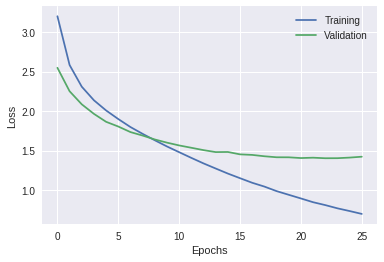

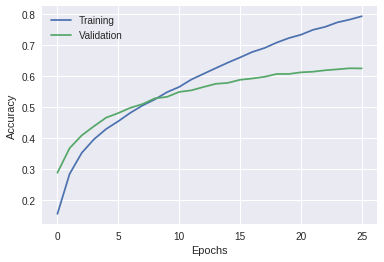

Test accuracy: 61.38%


In [90]:
#plot learning history
plot_history(history)

# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test accuracy: %.2f%%" % (scores[2]*100))